In [21]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [22]:
sys.path.append('../')
%load_ext autoreload
%autoreload 2
%store -r dm
dm = dm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
train_a = dm.train_a
train_b = dm.train_b
train_c = dm.train_c

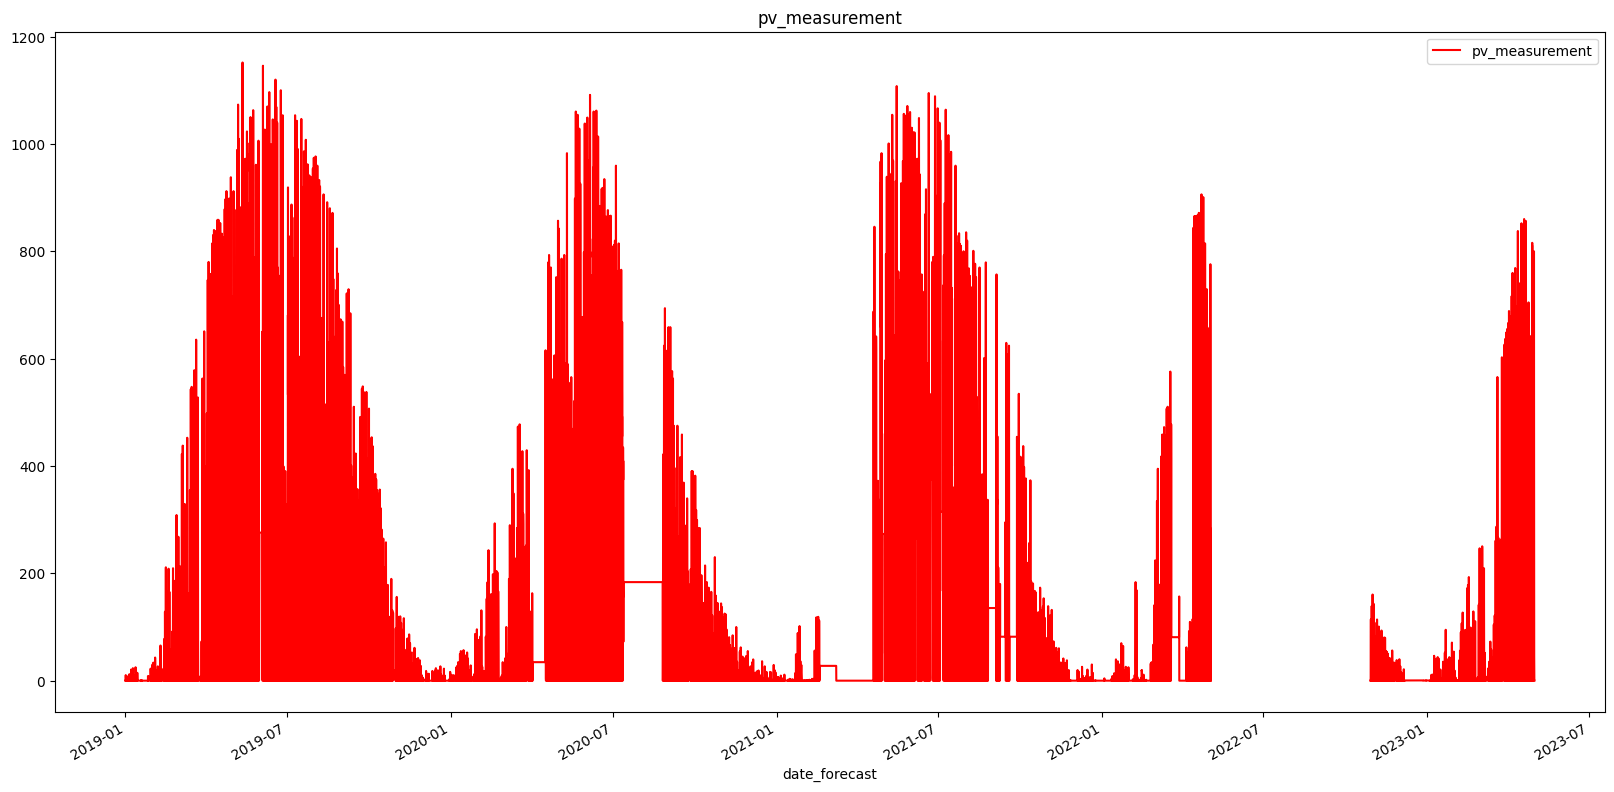

In [24]:
dm.plot_feature(train_b, 'pv_measurement')

In [25]:
# Resample targets to 15 minute
resampled_targets_a, resampled_targets_b, resampled_targets_c  = dm.resample_data([train_a, train_b, train_c], '15T')

In [26]:
resampled_targets_a.head(20)

,pv_measurement,date_forecast
0,0.00,2019-06-02 22:00:00
1,NaN,2019-06-02 22:15:00
2,NaN,2019-06-02 22:30:00
3,NaN,2019-06-02 22:45:00
4,0.00,2019-06-02 23:00:00
5,NaN,2019-06-02 23:15:00
6,NaN,2019-06-02 23:30:00
7,NaN,2019-06-02 23:45:00
8,0.00,2019-06-03 00:00:00
9,NaN,2019-06-03 00:15:00


In [27]:
# Run to save as csv's

"""
resampled_targets_a.to_csv("../csv_files/res15_a.csv")
resampled_targets_b.to_csv("../csv_files/res15_b.csv")
resampled_targets_c.to_csv("../csv_files/res15_c.csv")
"""

'\nresampled_targets_a.to_csv("../csv_files/res15_a.csv")\nresampled_targets_b.to_csv("../csv_files/res15_b.csv")\nresampled_targets_c.to_csv("../csv_files/res15_c.csv")\n'

In [28]:
from scipy.interpolate import Akima1DInterpolator

# Fill NaN with makima interpolation
def makima_interpolate(data: pd.DataFrame) -> pd.DataFrame:
    # Extract non-missing values and their indices
    non_nan_indices = data['pv_measurement'].dropna().index
    non_nan_values = data['pv_measurement'].dropna().values

    # Apply the Modified Akima Interpolation
    akima = Akima1DInterpolator(non_nan_indices, non_nan_values)
    interpolated_values = akima(data.index)

    # Replace the original column with the interpolated values
    data['pv_measurement_interpolated'] = interpolated_values

    return data


In [29]:
interpolated_a = makima_interpolate(resampled_targets_a)
interpolated_b = makima_interpolate(resampled_targets_b)
interpolated_c = makima_interpolate(resampled_targets_c)

In [30]:
# Plot segment of target data

def plot_segment(data: pd.DataFrame, start_idx: int, end_idx: int):
    # Select a segment of the data for visualization
    subset_data = data.iloc[start_idx:end_idx]

    # Plot the data
    plt.figure(figsize=(14, 7))
    plt.plot(subset_data['date_forecast'], subset_data['pv_measurement'], 'o-', label='Original', markersize=4)
    plt.plot(subset_data['date_forecast'], subset_data['pv_measurement_interpolated'], 'x-', label='Interpolated', markersize=4)
    plt.xticks(rotation=45)
    plt.title('PV Measurements: Original vs. Interpolated')
    plt.xlabel('Date Forecast')
    plt.ylabel('PV Measurement')
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

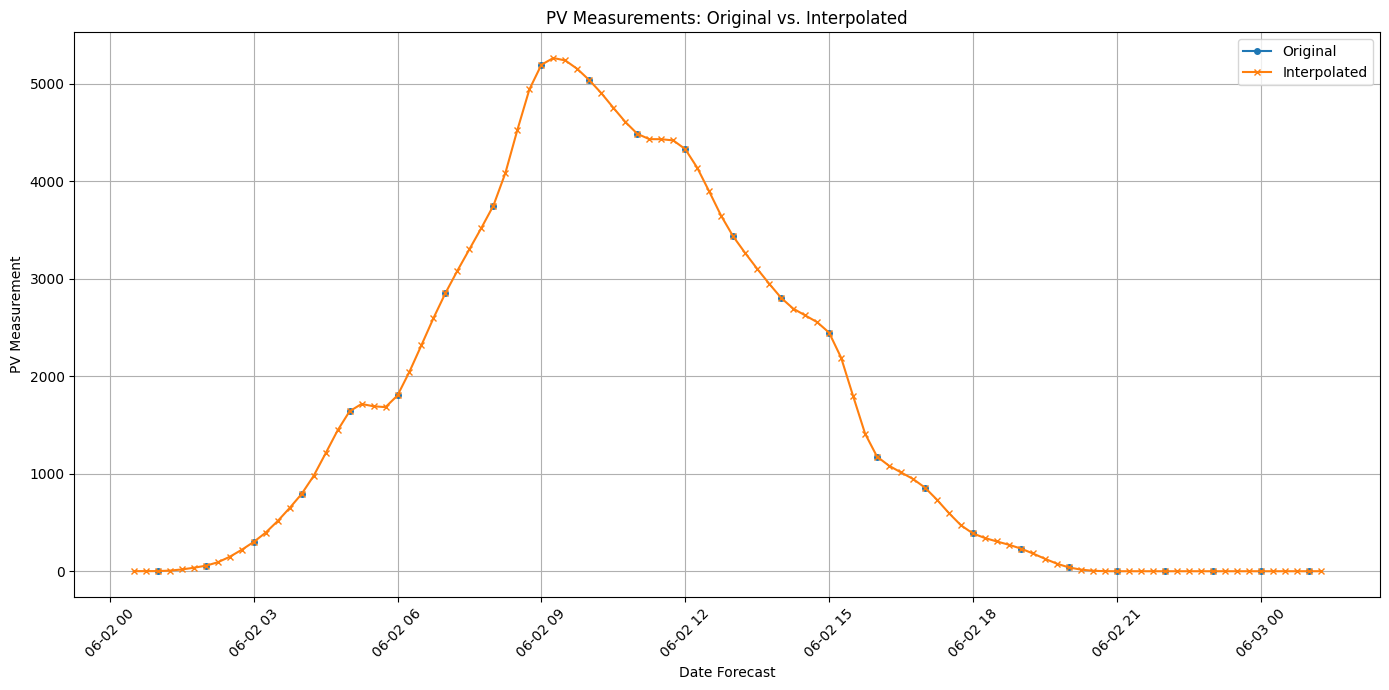

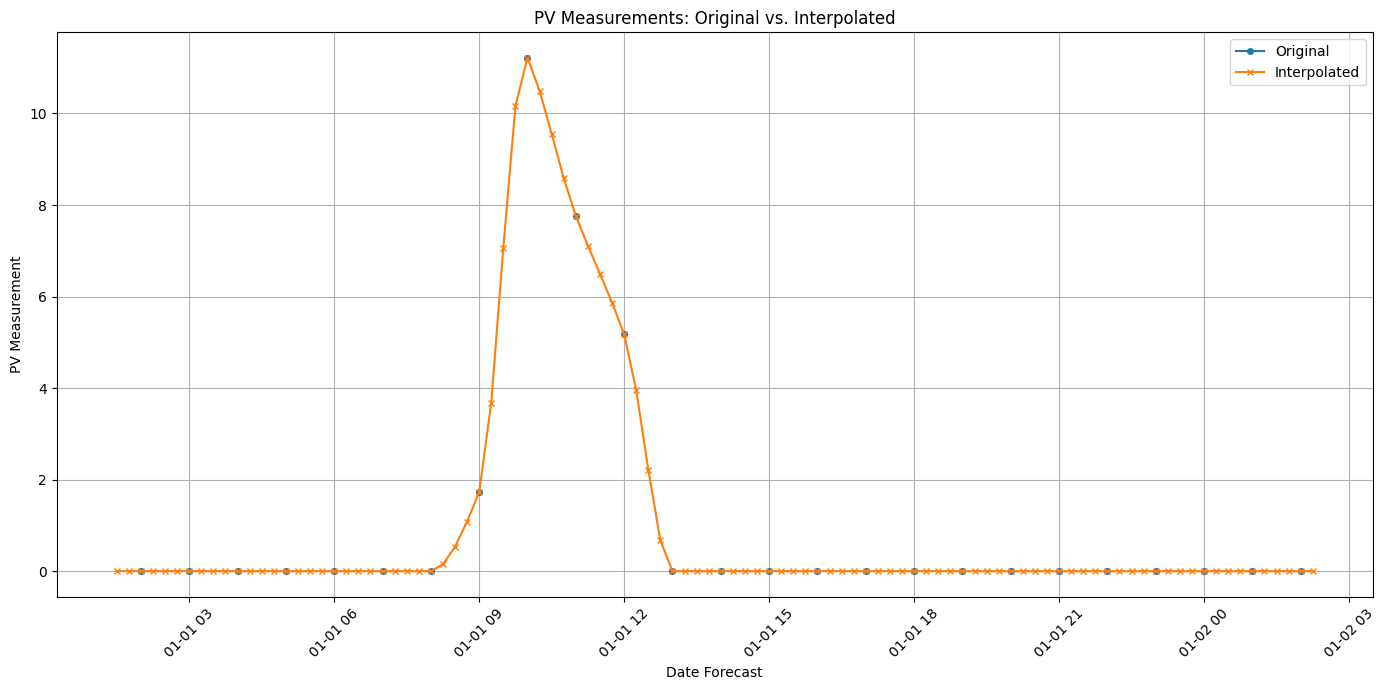

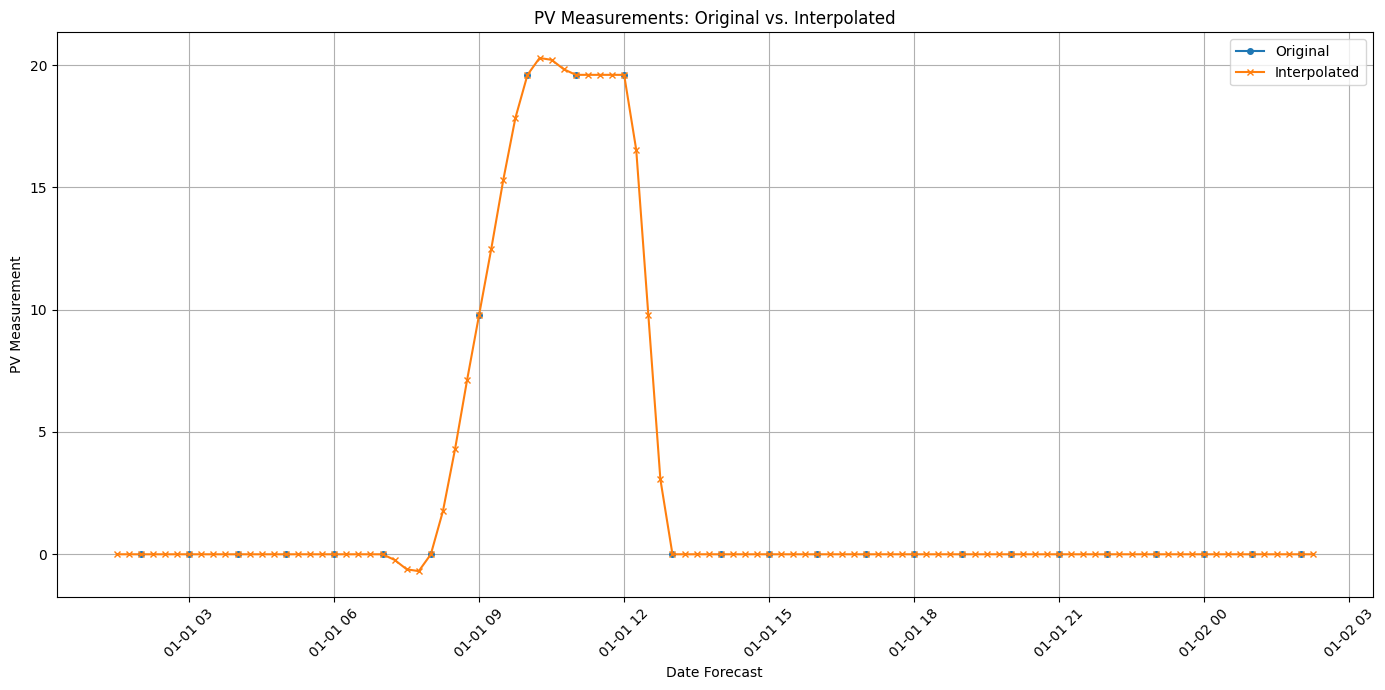

In [31]:
start_idx = 35050
end_idx = 35150

plot_segment(interpolated_a, start_idx, end_idx)
plot_segment(interpolated_b, start_idx, end_idx)
plot_segment(interpolated_c, start_idx, end_idx)

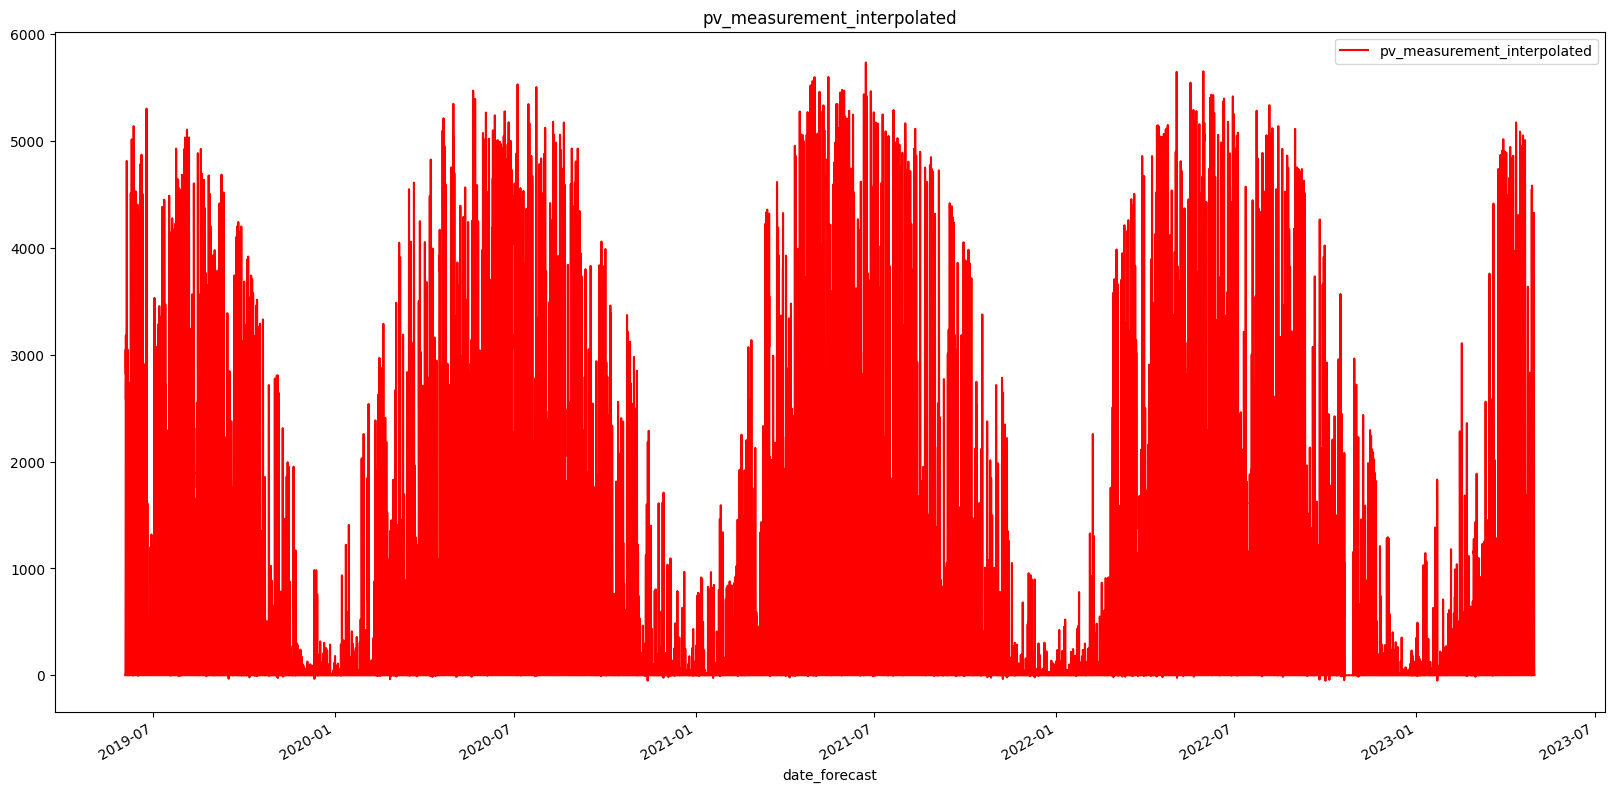

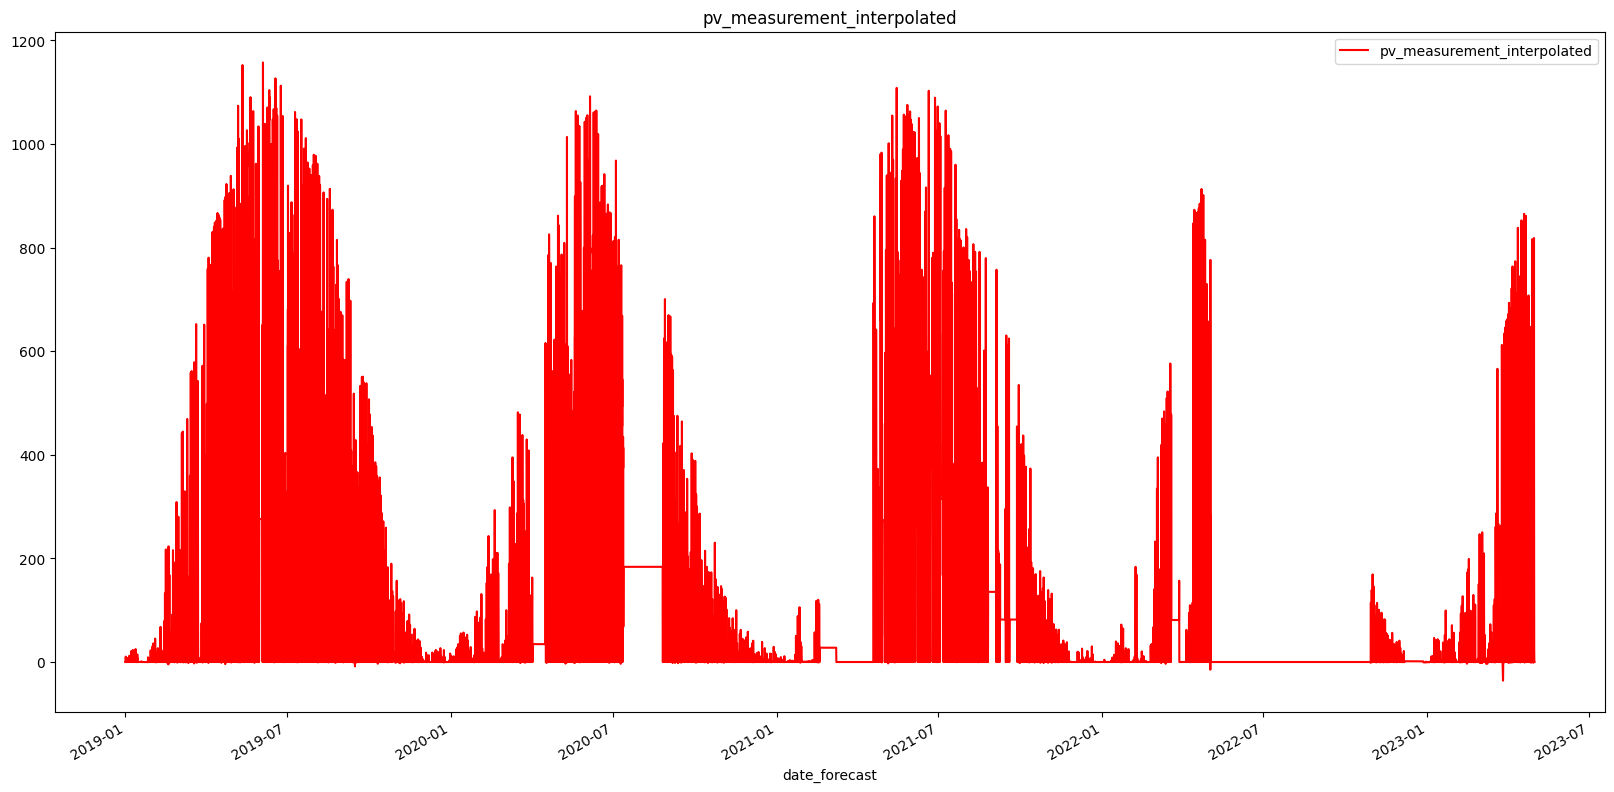

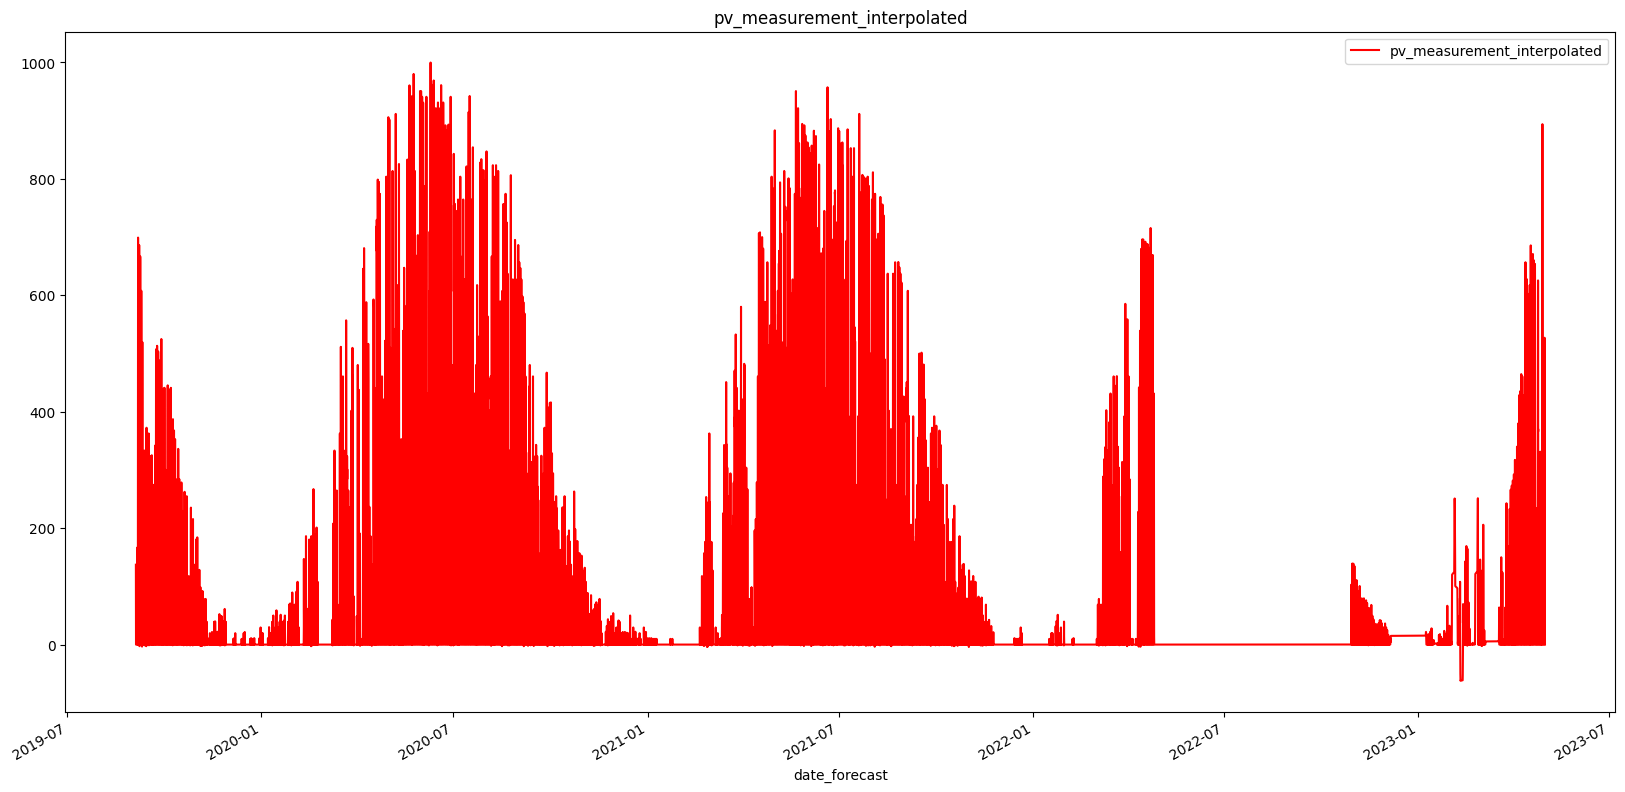

In [32]:
dm.plot_feature(interpolated_a, 'pv_measurement_interpolated')
dm.plot_feature(interpolated_b, 'pv_measurement_interpolated')
dm.plot_feature(interpolated_c, 'pv_measurement_interpolated')

### Deleting the rows where pvm is const

In [33]:
# Get const. intervals
# Grabs const_idx from teo_FE
%store -r const_idx
y_train_a_const_idx, y_train_b_const_idx, y_train_c_const_idx = const_idx

# Scale to match upscaled targets
y_train_a_const_idx = np.array(y_train_a_const_idx)*4
y_train_b_const_idx = np.array(y_train_b_const_idx)*4
y_train_c_const_idx = np.array(y_train_c_const_idx)*4

# Fill missing indices
def fill_next_three(list: np.ndarray):
    list2 = list.tolist()
    for x in list:
        list2.append(x+1)
        list2.append(x+2)
        list2.append(x+3)
    
    return list2

y_train_a_const_idx = fill_next_three(y_train_a_const_idx)
y_train_b_const_idx = fill_next_three(y_train_b_const_idx)
y_train_c_const_idx = fill_next_three(y_train_c_const_idx)

In [34]:
date_forecast_a_const = interpolated_a.iloc[y_train_a_const_idx]['date_forecast']
date_forecast_a_const_values = date_forecast_a_const.values
interpoladet_a = interpolated_a[~interpolated_a['date_forecast'].isin(date_forecast_a_const_values)]

date_forecast_b_const = interpolated_b.iloc[y_train_b_const_idx]['date_forecast']
date_forecast_b_const_values = date_forecast_b_const.values
interpolated_b = interpolated_b[~interpolated_b['date_forecast'].isin(date_forecast_b_const_values)]

date_forecast_c_const = interpolated_c.iloc[y_train_c_const_idx]['date_forecast']
date_forecast_c_const_values = date_forecast_c_const.values
interpolated_c = interpolated_c[~interpolated_c['date_forecast'].isin(date_forecast_c_const_values)]

In [ ]:
dm.plot_feature(interpolated_a, 'pv_measurement_interpolated')
dm.plot_feature(interpolated_b, 'pv_measurement_interpolated')
dm.plot_feature(interpolated_c, 'pv_measurement_interpolated')

### Deleting more rows

In [38]:
# Deletes rows with 4 consezu
def delete_excessive_rows(df):
    # Create a boolean series that identifies NaN values in the 'pv_measurement' column
    is_nan_series = df['pv_measurement'].isna()

    # Calculate the rolling sum of this boolean series, with a window size of 4
    rolling_sum = is_nan_series.rolling(window=4).sum()

    # Identify rows where the rolling sum is 4 (indicating 4 consecutive NaNs)
    to_remove = rolling_sum == 4

    # Identify indices of sequences to remove. We'll remove the sequence starting from
    # the first NaN in the sequence of 4 NaNs, so we need to get the index 3 places before
    indices_to_remove = df.index[to_remove].to_list()
    remove_start_indices = [i-3 for i in indices_to_remove]

    # Use list comprehension to generate all indices that should be removed
    all_indices_to_remove = [idx for start_idx in remove_start_indices for idx in range(start_idx, start_idx+4)]

    # Drop these indices from the dataframe
    df = df.drop(all_indices_to_remove).reset_index(drop=True)
    return df

interpolated_a = delete_excessive_rows(interpolated_a)
interpolated_b = delete_excessive_rows(interpolated_b)
interpolated_c = delete_excessive_rows(interpolated_c)

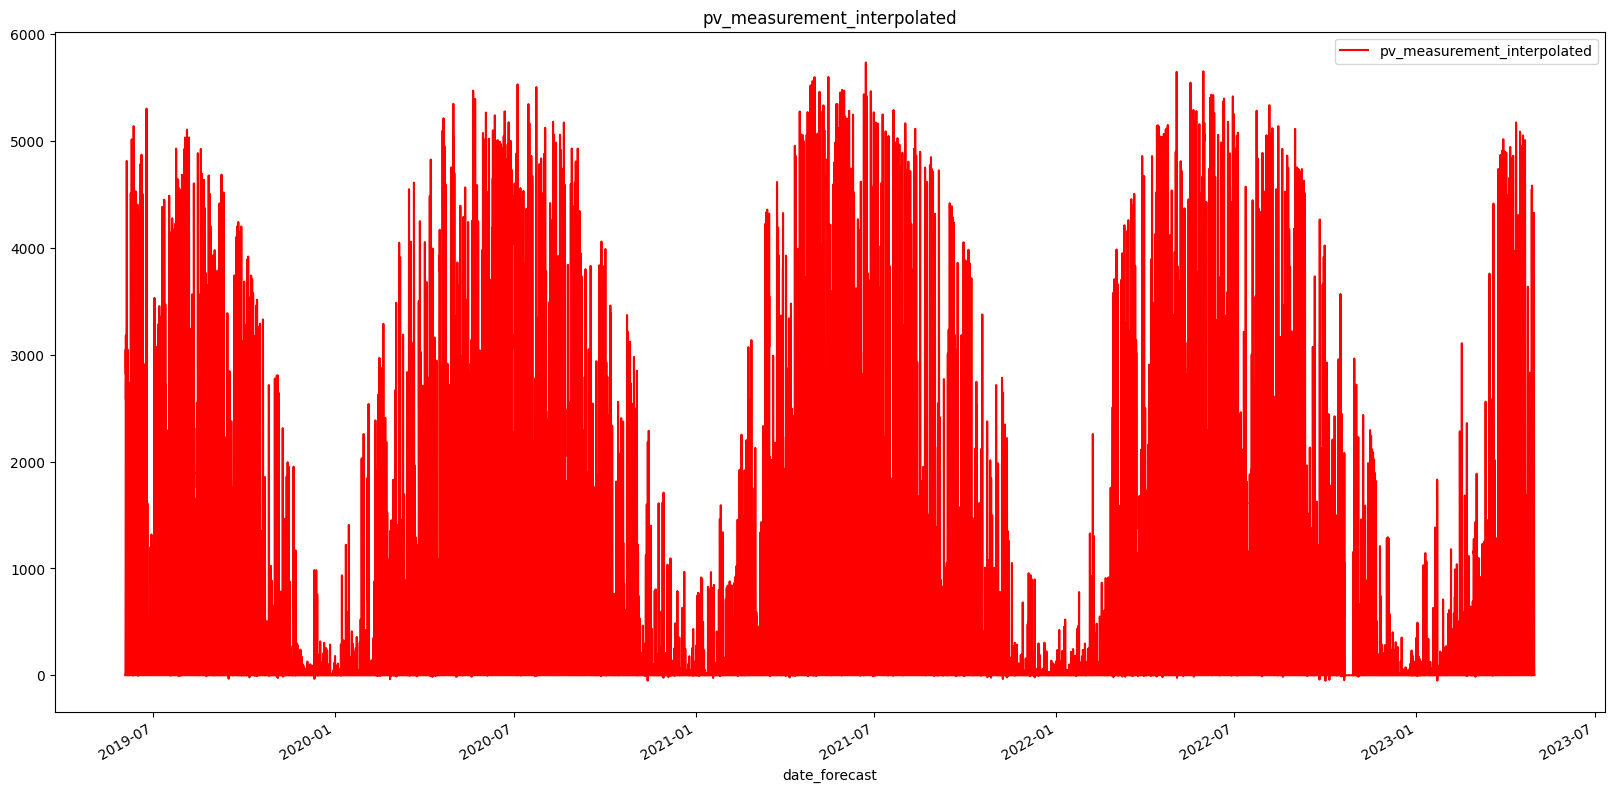

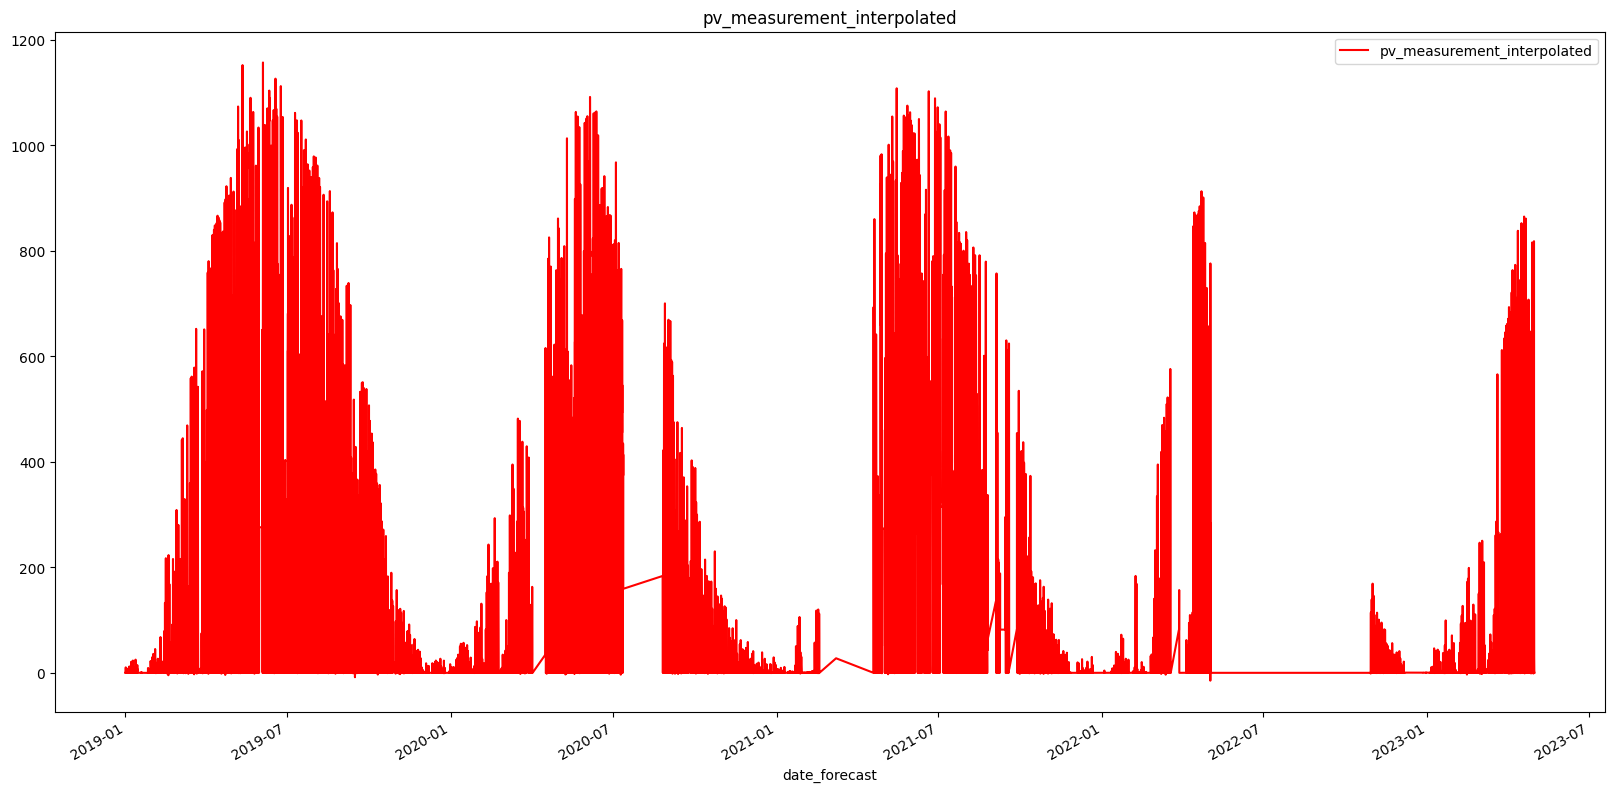

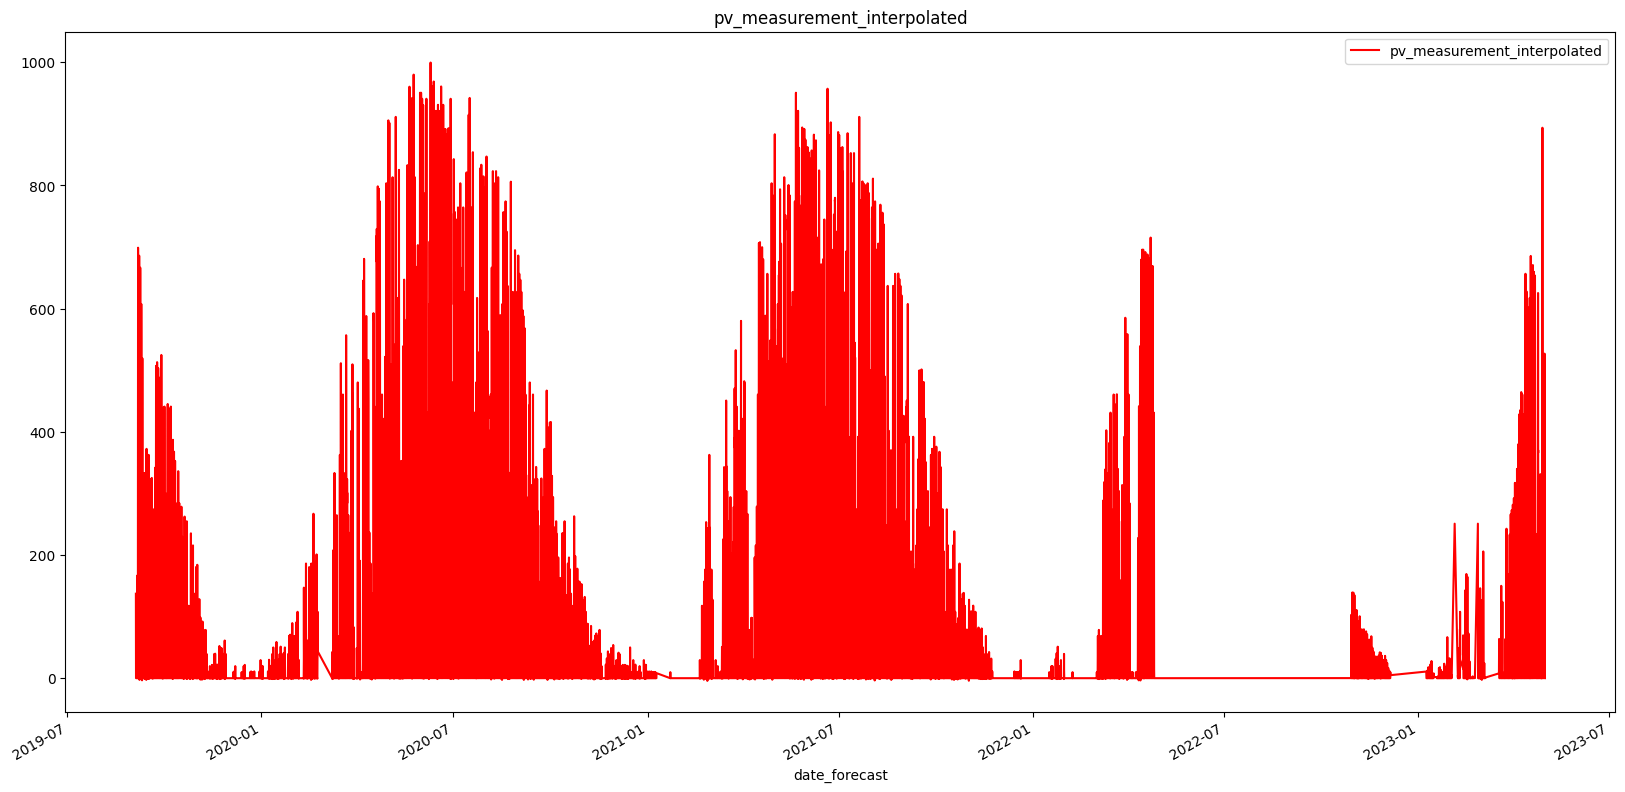

In [39]:
dm.plot_feature(interpolated_a, 'pv_measurement_interpolated')
dm.plot_feature(interpolated_b, 'pv_measurement_interpolated')
dm.plot_feature(interpolated_c, 'pv_measurement_interpolated')

In [41]:
def correct_negative_interpolated(df):
    """
    Detects rows where 'pv_measurement_interpolated' is negative and sets them to 0.0.

    Args:
    - df (pd.DataFrame): DataFrame containing the 'pv_measurement_interpolated' column.

    Returns:
    - pd.DataFrame: Updated DataFrame with negative 'pv_measurement_interpolated' values set to 0.0.
    """
    df.loc[df['pv_measurement_interpolated'] < 0, 'pv_measurement_interpolated'] = 0.0
    return df

# Apply the function to the dataframe
interpolated_a = correct_negative_interpolated(interpolated_a)
interpolated_b = correct_negative_interpolated(interpolated_b)
interpolated_c = correct_negative_interpolated(interpolated_c)

In [42]:
# Save files

"""
interpolated_a.to_csv("../csv_files/makima_a.csv")
interpolated_b.to_csv("../csv_files/makima_b.csv")
interpolated_c.to_csv("../csv_files/makima_c.csv")
"""